<b><font size="+1.5">Simulation of Nuclear Quadrupole Resonance Spectrum using a Hybrid Quantum Spin Register</b></font>
<hr>
This notebook implements a simulation of nuclear quadrupole resonance (NQR) spectra using a single electronic spin qubit as a sensor and a proximal nuclear spin as a target. While both spins can be of arbitrary size, the most interesting case is when the nuclear spin is quadrupolar (I > 1/2).
<br>

In [1]:
import numpy as np
import scipy.linalg as sp
import numpy.matlib as npm
import matplotlib as mpl
import matplotlib.pyplot as plt
% matplotlib inline

First we define a Hamiltonian class which can be used to construct a matrix representation of a Hamiltonian operator for a composite two-spin system. The electronic spin part of the Hamiltonian is given by 

\begin{align}
H_{e} = \Delta S_z^2 + \hbar \gamma_e \textbf{S} \cdot \textbf{B},
\end{align}

where $\textbf{S}$ = $\{S_x,S_y,S_z\}$ are the generalized Pauli spin operators, $\Delta$ is the zero-field interaction parameter, $\hbar$ is the reduced Planck's constant, $\gamma_e$ is the electron gyromagnetic ratio and $\textbf{B}$ is the external applied magnetic field. The first term of this Hamiltonian corresponds to the zero field splitting while the second term is the Zeeman interaction.

The nuclear spin part of the Hamiltonian is given by

\begin{align}
H_{n} = \frac{\overline{Q}}{4I(2I-1)} \Big[ 3 I_z^2 - I^2 + \eta (I_x^2 - I_y^2) \Big]  + \hbar \gamma_n \textbf{I} \cdot \textbf{B},
\end{align}

where $\textbf{I}$ = $\{I_x,I_y,I_z\}$ are the generalized spin operators for the nuclear spin, $\overline{Q}$ is the quadrupole coupling constant, $\eta$ is the asymmetry parameter and $\gamma_n$ is the nuclear gyromagnetic ratio. Here the first term corresponds to the nuclear electric quadrupole interaction while the second term is the nuclear Zeeman interaction. The resonance frequencies of the NQR spectrum are determined by applied magnetic field $\textbf{B}$ and $\overline{Q}$, which is the product of the scalar nuclear electric quadrupole moment and the largest eigenvalue of the local electric field gradient tensor.

Finally, the dipolar interaction term is given by

\begin{align}
H_{int} = \frac{\mu_0 \gamma_e \gamma_n \hbar^2}{4 \pi |\textbf{r}|^3} \Big[ 3\big( \textbf{S} \cdot \hat{\textbf{r}}\big) \big(\textbf{I} \cdot \hat{\textbf{r}}\big) - \big(\textbf{S} \cdot \textbf{I}\big) \Big],
\end{align}

where $\mu_0$ is the vacuum permeability and $\textbf{r}$ is the displacement vector of the two spins. The most general Hamiltonian considered in this simulation is given by 

\begin{align}
H = H_{e} + H_{n} + H_{int}.
\end{align}
<br>

In [2]:
class Hamiltonian:
    """
    This is a Hamiltonian operator class that allows us to construct a matrix representation 
    for a two-spin Hamiltonian. The two spins correspond to electronic and nuclear spins of 
    arbitrary size. The interactions that can be included are the zero-field splitting (ZFS) 
    term (for electronic spin), the Zeeman interaction, the Quadrupolar interaction 
    (including the quadrupole coupling constant and a non-zero asymmetry parameter), and a 
    dipolar coupling term.        
        
    """
    
    def __init__(self,spin_e,spin_n,Egyro,Ngyro):
        """
        The __init__ method creates a Hamiltonian object. The 'e', 'n', 'Egyro' and 'Ngyro 
        fields are initialized. The set containing term labels is initialized to the empty 
        set and the matrix representation is initialized to the zero matrix. The method 
        calls function 'createSpinOperators' to construct the generalized Pauli spin vector 
        operators for the electronic and nuclear spins. 
        
        Args: 
            spin_e: Spin quantum number of electronic spin.
            spin_n: Spin quantum number of nuclear spin.
            Egyro: Electronic spin gyromagnetic ratio.
            Ngyro: Nuclear spin gyromagnetic ratio.
            
        """
        
        self.e = spin_e
        self.n = spin_n
        
        self.Egyro = Egyro
        self.Ngyro = Ngyro
        
        # create spin operators
        self.eSpinOperators = createSpinOperators(spin_e)
        self.nSpinOperators = createSpinOperators(spin_n)
        
        # initialize matrix representation
        HilbSpace_size = int(2*spin_e+1)*int(2*spin_n+1) # dimension of Hilbert space
        self.H_MatrixRep = npm.zeros((HilbSpace_size,HilbSpace_size), dtype = np.complex)
        self.terms = set()
    
    def __str__(self):
        """
        This method prints a string containing the current terms in the Hamiltonian
        
        Args: 
            None
            
        """
        
        outstring = 'Current Hamiltonian terms: '
        for item in self.terms:
            outstring += item + ', '
        outstring = outstring[0:-2]
        return outstring
    
    def add_ZFS(self,D):
        """
        This method creates a ZFS term in the Hamiltonian. Asymmetry parameter is not 
        considered here. The ZFS term is added to the Hamiltonian matrix representation 
        and a separate matrix is created. 
        
        Args: 
            D: Electronic ZFS magnitude [Hz]. 
            
        """
        if 'ZFS' not in self.terms:
            self.ZFS_MatrixRep = C['hbar']*2*np.pi*D* \
                np.kron(self.eSpinOperators[2]**2,self.nSpinOperators[3])

            # add to total Hamiltonian matrix representation
            self.H_MatrixRep += self.ZFS_MatrixRep
            self.terms.add('ZFS') # add label to terms list
        else:
            print('Hamiltonian already contains ZFS term.')
        
    def add_Zeeman(self,B):
        """
        This method creates a Zeeman term in the Hamiltonian. Both the electron and 
        nuclear parts are included. The Zeeman term is added to the Hamiltonian matrix 
        representation and a separate matrix is created. 
        
        Args: 
            B: List of components of external applied magnetic field [G]. 
            
        """
        if 'Zeeman' not in self.terms:
            self.Zeeman_MatrixRep = npm.zeros(self.H_MatrixRep.shape, dtype = np.complex)
            for i in range(3):
                self.Zeeman_MatrixRep += C['hbar']*2*np.pi*B[i]* \
                    (self.Egyro*np.kron(self.eSpinOperators[i],self.nSpinOperators[3])) 
                self.Zeeman_MatrixRep += C['hbar']*2*np.pi*B[i]* \
                    (self.Ngyro*np.kron(self.eSpinOperators[3],self.nSpinOperators[i]))

            # add to total Hamiltonian matrix representation
            self.H_MatrixRep += self.Zeeman_MatrixRep
            self.terms.add('Zeeman') # add label to terms list
        else: 
            print('Hamiltonian already contains Zeeman term.')
            
    def add_nuclearQuadrupolar(self,Q,eta,NVang):
        """
        This method creates a nuclear Quadrupolar term in the Hamiltonian. The 
        quadrupolar term is added to the Hamiltonian matrix representation and a separate 
        matrix is created. 
        
        Args: 
            Q: Quadrupole coupling constant [Hz].
            eta: Asymmetry parameter.
            NVang: Symmetry axis orientation (in radians) for electron spin.
            
        """
        
        if 'Nuclear Quadrupolar' not in self.terms:
            # create rotation matrix for transformation into NV coordinate system
            RotMatrix = rotateMatrix([NVang,0,0])

            # Initialize Quadrupolar Matrix
            Cmat = C['hbar']*2*np.pi*Q/(4*self.n*(2*self.n-1))* \
                np.array([[eta,0,0],[0,-eta,0],[0,0,3]])
            Cmat = np.linalg.inv(RotMatrix)*Cmat*RotMatrix # transform to NV coordinates

            # populate Quadrupolar terms
            self.nuclearQuadrupolar_MatrixRep = npm.zeros(self.H_MatrixRep.shape, \
                                                          dtype = np.complex)
            for i in range(3):
                for j in range(3):
                    self.nuclearQuadrupolar_MatrixRep += Cmat[i,j]* \
                        np.kron(self.eSpinOperators[3],self.nSpinOperators[i]* \
                                self.nSpinOperators[j])

            # add to total Hamiltonian matrix representation
            self.H_MatrixRep += self.nuclearQuadrupolar_MatrixRep
            self.terms.add('Nuclear Quadrupolar') # add label to terms list
        else: 
            print('Hamiltonian already contains nuclear quadrupolar term.')
        
    def add_dipolarInteraction(self,disp,NVang):
        """
        This method creates a dipolar interaction term in the Hamiltonian. The dipolar term 
        is added to the Hamiltonian matrix representation and a separate matrix is created. 
        
        Args: 
            Q: Displacement of electronic and nuclear spins [nm].
            NVang: Symmetry axis orientation (in radians) for electron spin.
            
        """

        if 'Dipolar Interaction' not in self.terms:
            disp = np.asmatrix(disp) # convert displacement into NumPy matrix 
            disp = disp*10**-9 # convert displacement vector to nanometers

            # create rotation matrix for transformation into NV coordinate system
            RotMatrix = rotateMatrix([NVang,0,0])
            nr = RotMatrix*disp.T/np.linalg.norm(disp) # unit displacement vector

            # dipolar interaction strength
            Interaction_strength = (C['u_0']*(2*np.pi*10**4*C['hbar'])**2* \
                                    self.Egyro*self.Ngyro)/(4*np.pi*np.linalg.norm(disp)**3)

            # populate anisotropic dipolar terms
            self.dipolarInteraction_MatrixRep = npm.zeros(self.H_MatrixRep.shape, \
                                                          dtype = np.complex)
            for i in range(3):
                for j in range(3):
                    self.dipolarInteraction_MatrixRep -= 3*Interaction_strength* \
                        float(nr[i])*np.kron(self.eSpinOperators[i],self.nSpinOperators[j])

            # populate isotropic dipolar terms
            for i in range(3):
                self.dipolarInteraction_MatrixRep += Interaction_strength* \
                    np.kron(self.eSpinOperators[i],self.nSpinOperators[i])

            # add to total Hamiltonian matrix representation
            self.H_MatrixRep += self.dipolarInteraction_MatrixRep
            self.terms.add('Dipolar Interaction') # add label to terms list   
        else: 
            print('Hamiltonian already contains dipolar interaction term.')

    def remove_ZFS(self):
        """
        This method removes the ZFS term from the Hamiltonian and the terms list set.
        
        Args: 
            None 
            
        """
        if 'ZFS' in self.terms:
            self.H_MatrixRep -= self.ZFS_MatrixRep # remove from Hamiltonian
            self.ZFS_MatrixRep = None
            self.terms.remove('ZFS') # remove label from terms list set
        else:
            print('Hamiltonian has no ZFS term.')
            
    def remove_Zeeman(self):
        """
        This method removes the Zeeman term from the Hamiltonian and the terms list set.
        
        Args: 
            None 
            
        """
        if 'Zeeman' in self.terms:
            self.H_MatrixRep -= self.Zeeman_MatrixRep # remove from Hamiltonian
            self.Zeeman_MatrixRep = None
            self.terms.remove('Zeeman') # remove label from terms list set
        else:
            print('Hamiltonian has no Zeeman term.')
            
    def remove_nuclearQuadrupolar(self):
        """
        This method removes the nuclear quadrupolar term from the Hamiltonian and the terms 
        list set.
        
        Args: 
            None 
            
        """
        if 'Nuclear Quadrupolar' in self.terms:
            self.H_MatrixRep -= self.nuclearQuadrupolar_MatrixRep # remove from Hamiltonian
            self.nuclearQuadrupolar_MatrixRep = None
            self.terms.remove('Nuclear Quadrupolar') # remove label from terms list set
        else:
            print('Hamiltonian has no nuclear quadrupolar term.')
            
    def remove_dipolarInteraction(self):
        """
        This method removes the dipolar interaction term from the Hamiltonian and the terms 
        list set.
        
        Args: 
            None 
            
        """
        if 'Dipolar Interaction' in self.terms:
            self.H_MatrixRep -= self.dipolarInteraction_MatrixRep # remove from Hamiltonian
            self.dipolarInteraction_MatrixRep = None
            self.terms.remove('Dipolar Interaction') # remove label from terms list set
        else:
            print('Hamiltonian has no dipolar interaction term.')

Here we also need to create a number of ancillary functions to <br>
    1). initialize the state of the system <br>
    2). generate the spectrum using a custom Hamiltonian <br>
    3). output the results to a text file

In [3]:
def createSpinOperators(spin):
    """
    This function creates a set of generalized Pauli spin operators for spin of arbitrary 
    size. 
    
    Args: 
        spin (float): Spin quantum number [ex. 1.5].
        
    Returns:
        List of generalized spin matrices consisting of sigma-x, sigma-y, sigma-z and the 
        identity.
        
    """
    
    num_states = int(2*spin+1) # dimension of Hilbert space
    
    # initialize Sigma matrices
    Sigma_X = npm.zeros((num_states,num_states), dtype = np.complex)
    Sigma_Y = npm.zeros((num_states,num_states), dtype = np.complex)
    Sigma_Z = npm.zeros((num_states,num_states), dtype = np.complex)

    # Populate diagonal elements of Sigma_Z
    for i in range(num_states):
        Sigma_Z[i,i] = spin - i


    # Calculate off-diagonal elements for Sigma_X and Sigma_Y
    off_diag_entries = []
    for i in range(num_states-1):
        if i:
            next_entry = abs(2*(spin - i) + off_diag_entries[i-1]**2)
            off_diag_entries.append(np.sqrt(next_entry))
        else:
            next_entry = abs(2*(spin - i))
            off_diag_entries.append(np.sqrt(next_entry))
    
    # Populate off-diagonal elements of Sigma_X and Sigma_Y
    cnt = 0
    for entry in off_diag_entries:
        Sigma_X[cnt,cnt+1] = entry/2
        Sigma_X[cnt+1,cnt] = entry/2
        Sigma_Y[cnt,cnt+1] = -1j*entry/2
        Sigma_Y[cnt+1,cnt] = 1j*entry/2
        cnt += 1
        
    # Create Identity
    Sigma_0 = npm.identity(int(2*spin+1), dtype = int) 
        
    return [Sigma_X, Sigma_Y, Sigma_Z, Sigma_0]

def rotateMatrix(ang):
    """
    This function creates a composite rotation matrix for a list of angles about X,Y and 
    Z axes, respectively.
    
    Args: 
        ang : List of angles (in radians) for rotations about x,y and z axes, respectively.
        
    Returns:
        NumPy matrix (of size 3x3) for composite rotation.
        
    """

    # Define 3D rotation matrices for angle vector ang
    Rotx_3D = np.mat([[1,0,0],[0,np.cos(ang[0]),-np.sin(ang[0])], \
                      [0,np.sin(ang[0]),np.cos(ang[0])]])
    Roty_3D = np.mat([[np.cos(ang[1]),0,np.sin(ang[1])],[0,1,0], \
                      [-np.sin(ang[1]),0,np.cos(ang[1])]])
    Rotz_3D = np.mat([[np.cos(ang[2]),-np.sin(ang[2]),0], \
                      [np.sin(ang[2]),np.cos(ang[2]),0],[0,0,1]])
    
    return Rotx_3D*Roty_3D*Rotz_3D

def initializeState(S1,I1,spin_e,spin_n):
    """
    This function creates set of initial states (columns of istate) for composite spin object 
    given by Kronecker tensor product combining Hilbert spaces of electronic and nuclear spins.
    
    Args: 
        S1: Identity matrix for electronic spin.
        I1: Identity  matrix for nuclear spin.
        spin_e: Spin quantum number of electronic spin.
        spin_n: Spin quantum number of nuclear spin.
        
    Returns:
        NumPy matrix whose columns consist of possible initial states of composite spin object.
        
    """
    
    num_states_e = int(2*spin_e+1) # dimension of Hilbert space for electronic spin
    num_states_n = int(2*spin_n+1) # dimension of Hilbert space for nuclear spin

    istate = npm.zeros((num_states_e*num_states_n,num_states_n))
    for i in range(num_states_n):
        istate[:,i] = np.kron(S1[:,1],I1[:,i])
    return istate

def constructPulses(I1):
    """
    This function constructs a pi-pulse and pi/2-pulse on the composite spin object where the
    electronic part is rotated.
    
    Args: 
        I1: Identity  matrix for nuclear spin.
        
    Returns:
        NumPy matrices for pi- and pi/2-pulses on composite spin object.
        
    """

    pi2_pulse = rotateMatrix([0,0,-np.pi/4])
    pi_pulse = rotateMatrix([0,0,-np.pi/2])
    
    return np.kron(pi2_pulse,I1),np.kron(pi_pulse,I1)

def generateSpectrum(H,istate,Pi2,Pi,tau,Npi,C):
    """
    This function generates population spectrum for input list of tau values. Here tau 
    corresponds to the spacing of the pi-rotations in the applied XY control sequence. 
    Sequence corresponds to pi/2 - tau - pi - tau - pi - tau ... tau - pi - tau - pi/2.
    
    Args: 
        H: Hamiltonian operator matrix representation for composite spin.
        istate: NumPy matrix whose columns correspond to initial states of composite spin.
        Pi2: NumPy matrix corresponding to pi/2-rotation of electronic part of composite spin.
        Pi: NumPy matrix corresponding to pi-rotation of electronic part of composite spin.
        tau: List of inter-pulse spacings to evaluate spectrum [s].
        Npi: Number of applied pi-pulses.
        C: Dictionary of constant names and values.
        
    Returns:
        List of floats corresponding to population spectrum.
        
    """
    
    spec = np.zeros(len(tau))
    for i in range(len(tau)):
        
        # define propagator operator
        propagator = sp.expm(-1j*H*tau[i]/C['hbar'])
        
        # evolve state through XY sequence
        state = Pi2*propagator*(Pi*propagator)**Npi*Pi2*istate
        populations = np.multiply(np.conj(state),state)
    
        # average of populations taken over all initial states of nuclear spin
        for k in range(istate.shape[1]):
            spec[i] += (np.sum(populations[0:istate.shape[1]-1,k]))/istate.shape[1]

    return spec

def initializeParameters():
    """
    This function reads in text file containing spectrum parameters and creates dictionary 
    containing variable names and values.
    
    Args: 
        None
        
    Returns:
        Python dictionary containing key/value pairs corresponding to parameter names and 
        value.
        
    """

    # open text file containing parameter values
    F = open('parameters.txt', 'r')
    parameter_text = F.readlines()
    F.close() 

    # populate dictionary
    pardict = {}
    for item in parameter_text:
        parrow = item.split()
        pardict[parrow[0]] = float(parrow[1])
    return pardict

def initializeConstants():
    """
    This function reads in text file containing fundamental constants and creates dictionary 
    containing constant names and values.
    
    Args: 
        None
        
    Returns:
        Python dictionary containing key/value pairs corresponding to constant names and value.
        
    """

    # open text file containing parameter values
    F = open('constants.txt', 'r')
    constant_text = F.readlines()
    F.close()

    # populate dictionary
    constdict = {}
    for item in constant_text:
        constrow = item.split()
        constdict[constrow[0]] = float(constrow[1])
    return constdict

def outputSpectrum(tau,spec):
    """
    This function opens writes the tau values and simulated spectrum to a text file.
    
    Args: 
        tau: List of inter-pulse spacings to evalue spectrum [s].
        spec: Simulated spectrum.
        
    Returns:
        None
        
    """
    
    merged_spec = np.column_stack((tau,spec)) # merge tau and spec into two columns of array
    
    # open output file
    outfile = open('spectrum_output.txt', 'w')
    
    # write tau and spec values to output file
    for item in merged_spec:
        outfile.write(str(item[0]) + ' ' + str(item[1]) + "\n")
    outfile.close()

def spectrumSimulation(H,P,C):
    """
    This is the main function that runs the spectrum simulation. The spin operators are created 
    and the initial state of the composite spin is constructed. The function 'generateSpectrum' 
    is called to calculate the spectrum. The results are written to a text file.
    
    Args: 
        H: Hamitonian operator object
        P: Dictionary of parameter names and values
        C: Dictionary of constant names and values
        
    Returns:
        List of inter-pulse spacings to evaluate spectrum.
        List corresponding to population spectrum.
        
    """
    
    # initialize list of pi-pulse spacings
    tau = np.linspace(P['tau_min'],P['tau_max'],P['numpoints'])
    
    # construct generalized spin vector operators for electronic and nuclear spins
    S = createSpinOperators(P['spin_e'])
    I = createSpinOperators(P['spin_n'])

    # construct initial state
    istate = initializeState(S[3],I[3],P['spin_e'],P['spin_n'])

    # construct spin operations on composite spin object
    Pi2,Pi = constructPulses(I[3])

    # generate simulated spectrum
    spec = generateSpectrum(H.H_MatrixRep,istate,Pi2,Pi,tau,int(P['Npi']),C)

    # output spectrum to text file
    outputSpectrum(tau,spec)
    
    return tau,spec

<b>Now we can read in the parameters, create a Hamiltonian object and generate some spectra.</b><br>
As a demonstration, let's simulate the NQR spectra for a I = 2 nuclear spin with and without a quadrupole coupling constant.
<br>

In [4]:
#############################################
############ MODIFY THIS BLOCK ##############
#############################################
P = initializeParameters()

# initialize constants
C = initializeConstants()

# create Hamiltonian object
H = Hamiltonian(P['spin_e'],P['spin_n'],P['Egyro'],P['Ngyro'])

# add some terms to Hamiltonian
H.add_ZFS(P['NV_ZFS']) # add NV zero-field splitting
H.add_Zeeman([P['Bfieldx'],P['Bfieldy'],P['Bfieldz']]) # add Zeeman interactions
H.add_nuclearQuadrupolar(P['Q'],P['eta'],P['NVang']) # add nuclear Quadrupolar interaction
H.add_dipolarInteraction([P['dispx'],P['dispy'],P['dispz']],P['NVang']) # add dipolar interaction

# spectrum with a quadrupole coupling constant
tau,spec_quad = spectrumSimulation(H,P,C)

H.remove_nuclearQuadrupolar() # remove quadrupolar interaction

# spectrum with no quadrupole coupling constant
tau,spec_noquad = spectrumSimulation(H,P,C)

/Users/alice/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:145: ComplexWarning: Casting complex values to real discards the imaginary part


<b> Now we can plot the results! </b> <br>
We can see that the effect of the quadrupole coupling constant is to split the various spectral lines about the nuclear Larmor frequency (here centered at approximately 191 ns).

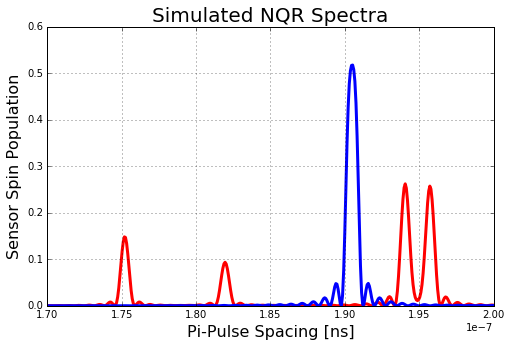

In [5]:
fig = plt.figure(figsize=[8,5])
plt.plot(tau,spec_quad,'red', linewidth = 3)
plt.plot(tau,spec_noquad,'blue', linewidth = 3)

axes = fig.add_subplot(111)
axes.set_title('Simulated NQR Spectra', fontsize = 20)
axes.set_xlabel('Pi-Pulse Spacing [ns]', fontsize = 16)
axes.set_ylabel('Sensor Spin Population', fontsize = 16)
plt.xlim(tau[0],tau[-1])
plt.grid(True)
plt.show()